In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

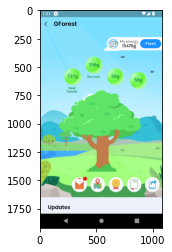

In [4]:
# Read the main image
img = cv.imread('sample_screenshot.png', cv.IMREAD_COLOR)

# Show both images
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

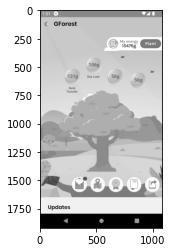

In [5]:
# Convert to graycsale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Blur the image for better edge detection
img_blur = cv.GaussianBlur(img_gray, (3,3), 0) 
plt.imshow(cv.cvtColor(img_blur, cv.COLOR_BGR2RGB))

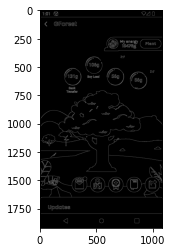

In [6]:
# Canny Edge Detection
edges = cv.Canny(image=img_blur, threshold1=1, threshold2=70)
plt.imshow(cv.cvtColor(edges, cv.COLOR_BGR2RGB))

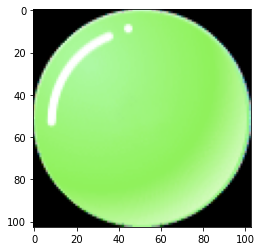

In [7]:
bubble_tmpl = cv.imread('bubble_tmpl.png', cv.IMREAD_COLOR)
plt.imshow(bubble_tmpl)

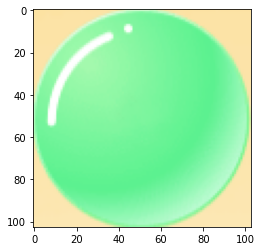

In [8]:
bubble_cropped = cv.imread('bubble_cropped.png', cv.IMREAD_COLOR)
plt.imshow(bubble_cropped)

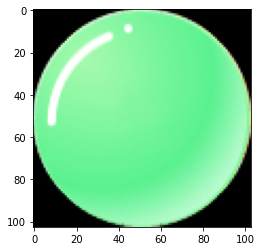

In [9]:
def remove_circlebg(image):
    hh, ww = image.shape[:2]
    hh2 = hh // 2
    ww2 = ww // 2

    # define circles
    radius = hh2
    yc = hh2
    xc = ww2

    # draw filled circle in white on black background as mask
    mask = np.zeros_like(image)
    mask = cv.circle(mask, (xc,yc), radius, (255,255,255), -1, lineType=cv.LINE_AA)

    # apply mask to image
    return cv.bitwise_and(image, mask)

plt.imshow(remove_circlebg(bubble_cropped))

In [10]:
def histogram(image):
    # Convert it to HSV
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    # extract a 3D RGB color histogram from the image,
    # using 8 bins per channel, normalize, and update
    # the index
    hist = cv.calcHist([image], [0, 1, 2], None, [8, 8, 8],
        [0, 256, 0, 256, 0, 256])
    return hist

In [11]:
bubble_hist = histogram(bubble_tmpl)

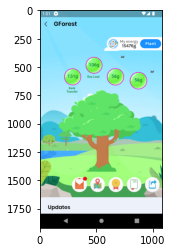

In [12]:
circles = cv.HoughCircles(edges,cv.HOUGH_GRADIENT, 1, 100, param2=40, minRadius=40, maxRadius=100)
img_circle = img.copy()
ris = []

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # circle parameters
        cx = i[0]
        cy = i[1]
        cr = i[2]

        # image slicing parameters
        x0 = cx - cr
        y0 = cy - cr
        x1 = cx + cr
        y1 = cy + cr

        # slice region of interest
        ri = remove_circlebg(img[y0:y1, x0:x1])

        # histogram comparison with bubble
        hist = histogram(ri)
        value = cv.compareHist(bubble_hist, hist, cv.HISTCMP_INTERSECT)
        
        if(value > 2500):
            ris.append(ri)

            # circle center
            cv.circle(img_circle, (cx, cy), 1, (0, 100, 100), 3)

            # circle outline
            cv.circle(img_circle, (cx, cy), cr, (255, 0, 255), 3)

cv.imwrite("result.png", img_circle)
plt.imshow(cv.cvtColor(img_circle, cv.COLOR_BGR2RGB))

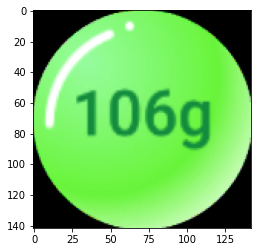

In [13]:
sample = ris[0]
plt.imshow(cv.cvtColor(sample, cv.COLOR_BGR2RGB))

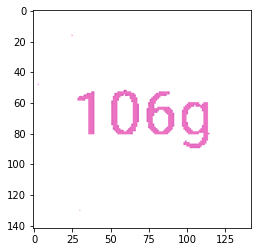

In [14]:
def text_threshold(image):
    # Threshold of blue in HSV space
    lower = np.array([67, 180, 30])
    upper = np.array([78, 255, 255])

    # Create HSV Image and threshold into a range.
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv, lower, upper)
    output = cv.bitwise_and(image, image, mask= mask)
    output = cv.bitwise_not(output)
    
    return output

result = text_threshold(sample)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))

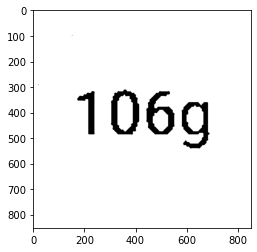

In [15]:
def binarize(image):
    # Convert to grayscale
    dst = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    dst = cv.threshold(dst, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

    # Erosion and dilasion
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,1))
    close = cv.morphologyEx(dst, cv.MORPH_CLOSE, kernel, iterations=2)

    return close

result = cv.resize(result, None, fx=6, fy=6, interpolation=cv.INTER_CUBIC)
plt.imshow(cv.cvtColor(binarize(result), cv.COLOR_BGR2RGB))

106g


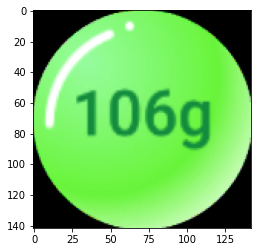

In [16]:
import pytesseract

def recognize_energy(image):
    # (1) Enlarge image
    result = cv.resize(image, None, fx=6, fy=6, interpolation=cv.INTER_CUBIC)

    # (2) Remove noise using bilateral filter
    result = cv.bilateralFilter(result,1,50,50)

    # (3) Remove background
    result = text_threshold(result)

    # (4) Threshold
    result = binarize(result)

    # (5) Recognize Text
    result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
    energy = pytesseract.image_to_string(result, config="-c tessedit_char_whitelist=0123456789g")

    return energy.strip()

plt.imshow(cv.cvtColor(sample, cv.COLOR_BGR2RGB))
print(recognize_energy(sample))

In [17]:
import pytesseract

energies = []

for ri in ris:
    energy = recognize_energy(ri)
    energies.append(energy)

print(energies)

['106g', '131g', '56g', '56g']


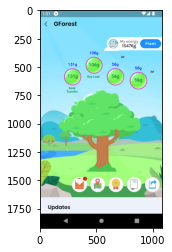

In [18]:
circles = cv.HoughCircles(edges,cv.HOUGH_GRADIENT, 1, 100, param2=40, minRadius=40, maxRadius=100)
img_circles = img.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # circle parameters
        cx = i[0]
        cy = i[1]
        cr = i[2]

        # image slicing parameters
        x0 = cx - cr
        y0 = cy - cr
        x1 = cx + cr
        y1 = cy + cr

        # slice region of interest
        ri = remove_circlebg(img[y0:y1, x0:x1])

        # histogram comparison with bubble
        hist = histogram(ri)
        value = cv.compareHist(bubble_hist, hist, cv.HISTCMP_INTERSECT)
        
        if(value > 2500):
            # Draw circle center
            cv.circle(img_circles, (cx, cy), 1, (0, 100, 100), 3)

            # Draw circle outline
            cv.circle(img_circles, (cx, cy), cr, (255, 0, 255), 3)

            # Recognize energy
            energy = recognize_energy(ri)

            # label circle
            font = cv.FONT_HERSHEY_SIMPLEX
            font_size = 1
            thickness = 2
            (text_width, text_height) = cv.getTextSize(energy, font, font_size, thickness)[0]
            tx = int(cx - text_width / 2)
            ty = int(cy - cr - text_height - 5)
            img_circles = cv.putText(img_circles, energy, (tx, ty), font, 
                            font_size, (255, 0, 0), thickness, cv.LINE_AA)

cv.imwrite("result.png", img_circles)
plt.imshow(cv.cvtColor(img_circles, cv.COLOR_BGR2RGB))